In [1]:
#IMPORTS

#File IO
import os
import glob

#Data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn.functional as F
from segmentation_models_pytorch import Unet

#Scikit learn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score

#Misc
from tqdm import tqdm


In [2]:
#HYPERPARMETERS

train_proportion = .8
val_proportion = .1

batch_size = 128
learning_rate = .00002
num_epochs = 100

In [3]:
#CREATE DATASET

dataset = torch.load("mask_unet_dataset.pt", weights_only=False)

In [4]:
#CREATE DATALOADERS

train_size = int(train_proportion * len(dataset))
val_size = int(val_proportion * len(dataset))
test_size = len(dataset) - train_size - val_size

generator = torch.Generator().manual_seed(1)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=generator)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
#CREATE MODEL

num_classes = 2
model = Unet(
    encoder_name="resnet34",
    in_channels=16,
    classes=num_classes
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
model = model.to(device)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [6]:
#TRAIN and EVALUATE FUNCTIONS

def train(model, train_loader):
    model.train()
    train_loss = correct = total = 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += (preds == labels).sum().item()
        total += labels.numel()

    #total is number of train instances
    avg_loss = train_loss/len(train_loader)
    accuracy = correct/total
    return avg_loss, accuracy

def eval(model, val_loader):
    model.eval()
    val_loss = correct = total = 0

    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)

        loss = criterion(outputs, labels)

        val_loss += loss.item()
        correct += (preds == labels).sum().item()
        total += labels.numel()

    avg_loss = val_loss/len(val_loader)
    accuracy = correct/total
    return avg_loss, accuracy

In [7]:
#TRAIN MODEL

for e in range(1, num_epochs+1):
    train_loss, train_acc = train(model, train_loader)
    val_loss, val_acc = eval(model, val_loader)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch: {e} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

100%|██████████| 94/94 [00:12<00:00,  7.56it/s]


Epoch: 1 | Train Loss: 0.6999 | Train Acc: 0.6048 | Val Loss: 0.5432 | Val Acc: 0.7811


100%|██████████| 94/94 [00:13<00:00,  7.07it/s]


Epoch: 2 | Train Loss: 0.4630 | Train Acc: 0.8653 | Val Loss: 0.4167 | Val Acc: 0.8922


100%|██████████| 94/94 [00:12<00:00,  7.43it/s]


Epoch: 3 | Train Loss: 0.3893 | Train Acc: 0.9024 | Val Loss: 0.3611 | Val Acc: 0.9128


100%|██████████| 94/94 [00:12<00:00,  7.41it/s]


Epoch: 4 | Train Loss: 0.3380 | Train Acc: 0.9189 | Val Loss: 0.3233 | Val Acc: 0.9172


100%|██████████| 94/94 [00:12<00:00,  7.61it/s]


Epoch: 5 | Train Loss: 0.2989 | Train Acc: 0.9282 | Val Loss: 0.3150 | Val Acc: 0.9154


100%|██████████| 94/94 [00:12<00:00,  7.47it/s]


Epoch: 6 | Train Loss: 0.2696 | Train Acc: 0.9360 | Val Loss: 0.2707 | Val Acc: 0.9291


100%|██████████| 94/94 [00:12<00:00,  7.47it/s]


Epoch: 7 | Train Loss: 0.2471 | Train Acc: 0.9401 | Val Loss: 0.2751 | Val Acc: 0.9230


100%|██████████| 94/94 [00:12<00:00,  7.56it/s]


Epoch: 8 | Train Loss: 0.2262 | Train Acc: 0.9439 | Val Loss: 0.2550 | Val Acc: 0.9249


100%|██████████| 94/94 [00:12<00:00,  7.54it/s]


Epoch: 9 | Train Loss: 0.2084 | Train Acc: 0.9466 | Val Loss: 0.2111 | Val Acc: 0.9405


100%|██████████| 94/94 [00:12<00:00,  7.64it/s]


Epoch: 10 | Train Loss: 0.1917 | Train Acc: 0.9495 | Val Loss: 0.2025 | Val Acc: 0.9411


100%|██████████| 94/94 [00:12<00:00,  7.42it/s]


Epoch: 11 | Train Loss: 0.1796 | Train Acc: 0.9510 | Val Loss: 0.2313 | Val Acc: 0.9222


100%|██████████| 94/94 [00:12<00:00,  7.52it/s]


Epoch: 12 | Train Loss: 0.1684 | Train Acc: 0.9526 | Val Loss: 0.2039 | Val Acc: 0.9334


100%|██████████| 94/94 [00:12<00:00,  7.50it/s]


Epoch: 13 | Train Loss: 0.1604 | Train Acc: 0.9532 | Val Loss: 0.1860 | Val Acc: 0.9398


100%|██████████| 94/94 [00:12<00:00,  7.50it/s]


Epoch: 14 | Train Loss: 0.1510 | Train Acc: 0.9552 | Val Loss: 0.1728 | Val Acc: 0.9443


100%|██████████| 94/94 [00:12<00:00,  7.77it/s]


Epoch: 15 | Train Loss: 0.1447 | Train Acc: 0.9560 | Val Loss: 0.1609 | Val Acc: 0.9467


100%|██████████| 94/94 [00:12<00:00,  7.42it/s]


Epoch: 16 | Train Loss: 0.1369 | Train Acc: 0.9579 | Val Loss: 0.1539 | Val Acc: 0.9487


100%|██████████| 94/94 [00:12<00:00,  7.46it/s]


Epoch: 17 | Train Loss: 0.1330 | Train Acc: 0.9580 | Val Loss: 0.1541 | Val Acc: 0.9471


100%|██████████| 94/94 [00:12<00:00,  7.50it/s]


Epoch: 18 | Train Loss: 0.1287 | Train Acc: 0.9586 | Val Loss: 0.1426 | Val Acc: 0.9515


100%|██████████| 94/94 [00:12<00:00,  7.75it/s]


Epoch: 19 | Train Loss: 0.1231 | Train Acc: 0.9600 | Val Loss: 0.1439 | Val Acc: 0.9503


100%|██████████| 94/94 [00:12<00:00,  7.65it/s]


Epoch: 20 | Train Loss: 0.1187 | Train Acc: 0.9610 | Val Loss: 0.1927 | Val Acc: 0.9313


100%|██████████| 94/94 [00:12<00:00,  7.33it/s]


Epoch: 21 | Train Loss: 0.1151 | Train Acc: 0.9616 | Val Loss: 0.1319 | Val Acc: 0.9533


100%|██████████| 94/94 [00:12<00:00,  7.62it/s]


Epoch: 22 | Train Loss: 0.1121 | Train Acc: 0.9622 | Val Loss: 0.1468 | Val Acc: 0.9471


100%|██████████| 94/94 [00:12<00:00,  7.63it/s]


Epoch: 23 | Train Loss: 0.1083 | Train Acc: 0.9632 | Val Loss: 0.1530 | Val Acc: 0.9442


100%|██████████| 94/94 [00:12<00:00,  7.52it/s]


Epoch: 24 | Train Loss: 0.1061 | Train Acc: 0.9634 | Val Loss: 0.1473 | Val Acc: 0.9469


100%|██████████| 94/94 [00:12<00:00,  7.61it/s]


Epoch: 25 | Train Loss: 0.1026 | Train Acc: 0.9644 | Val Loss: 0.1329 | Val Acc: 0.9504


100%|██████████| 94/94 [00:12<00:00,  7.59it/s]


Epoch: 26 | Train Loss: 0.1002 | Train Acc: 0.9651 | Val Loss: 0.1377 | Val Acc: 0.9498


100%|██████████| 94/94 [00:12<00:00,  7.59it/s]


Epoch: 27 | Train Loss: 0.0973 | Train Acc: 0.9656 | Val Loss: 0.1283 | Val Acc: 0.9527


100%|██████████| 94/94 [00:12<00:00,  7.53it/s]


Epoch: 28 | Train Loss: 0.0954 | Train Acc: 0.9658 | Val Loss: 0.1262 | Val Acc: 0.9540


100%|██████████| 94/94 [00:12<00:00,  7.62it/s]


Epoch: 29 | Train Loss: 0.0934 | Train Acc: 0.9663 | Val Loss: 0.1173 | Val Acc: 0.9565


100%|██████████| 94/94 [00:12<00:00,  7.70it/s]


Epoch: 30 | Train Loss: 0.0947 | Train Acc: 0.9653 | Val Loss: 0.1349 | Val Acc: 0.9510


100%|██████████| 94/94 [00:12<00:00,  7.63it/s]


Epoch: 31 | Train Loss: 0.0897 | Train Acc: 0.9673 | Val Loss: 0.1568 | Val Acc: 0.9407


100%|██████████| 94/94 [00:12<00:00,  7.83it/s]


Epoch: 32 | Train Loss: 0.0879 | Train Acc: 0.9677 | Val Loss: 0.1146 | Val Acc: 0.9566


100%|██████████| 94/94 [00:11<00:00,  7.85it/s]


Epoch: 33 | Train Loss: 0.0852 | Train Acc: 0.9687 | Val Loss: 0.1216 | Val Acc: 0.9546


100%|██████████| 94/94 [00:12<00:00,  7.77it/s]


Epoch: 34 | Train Loss: 0.0848 | Train Acc: 0.9685 | Val Loss: 0.1139 | Val Acc: 0.9570


100%|██████████| 94/94 [00:11<00:00,  7.87it/s]


Epoch: 35 | Train Loss: 0.0830 | Train Acc: 0.9691 | Val Loss: 0.1183 | Val Acc: 0.9561


100%|██████████| 94/94 [00:11<00:00,  7.86it/s]


Epoch: 36 | Train Loss: 0.0842 | Train Acc: 0.9683 | Val Loss: 0.1165 | Val Acc: 0.9556


100%|██████████| 94/94 [00:11<00:00,  7.83it/s]


Epoch: 37 | Train Loss: 0.0815 | Train Acc: 0.9693 | Val Loss: 0.1124 | Val Acc: 0.9568


100%|██████████| 94/94 [00:12<00:00,  7.77it/s]


Epoch: 38 | Train Loss: 0.0784 | Train Acc: 0.9705 | Val Loss: 0.1244 | Val Acc: 0.9530


100%|██████████| 94/94 [00:12<00:00,  7.75it/s]


Epoch: 39 | Train Loss: 0.0782 | Train Acc: 0.9704 | Val Loss: 0.1122 | Val Acc: 0.9573


100%|██████████| 94/94 [00:12<00:00,  7.50it/s]


Epoch: 40 | Train Loss: 0.0768 | Train Acc: 0.9708 | Val Loss: 0.1271 | Val Acc: 0.9540


100%|██████████| 94/94 [00:12<00:00,  7.62it/s]


Epoch: 41 | Train Loss: 0.0770 | Train Acc: 0.9706 | Val Loss: 0.1175 | Val Acc: 0.9560


100%|██████████| 94/94 [00:11<00:00,  7.89it/s]


Epoch: 42 | Train Loss: 0.0756 | Train Acc: 0.9711 | Val Loss: 0.1107 | Val Acc: 0.9585


100%|██████████| 94/94 [00:12<00:00,  7.73it/s]


Epoch: 43 | Train Loss: 0.0749 | Train Acc: 0.9712 | Val Loss: 0.1128 | Val Acc: 0.9557


100%|██████████| 94/94 [00:12<00:00,  7.54it/s]


Epoch: 44 | Train Loss: 0.0738 | Train Acc: 0.9715 | Val Loss: 0.1153 | Val Acc: 0.9561


100%|██████████| 94/94 [00:12<00:00,  7.62it/s]


Epoch: 45 | Train Loss: 0.0725 | Train Acc: 0.9720 | Val Loss: 0.1069 | Val Acc: 0.9597


100%|██████████| 94/94 [00:12<00:00,  7.73it/s]


Epoch: 46 | Train Loss: 0.0721 | Train Acc: 0.9720 | Val Loss: 0.1283 | Val Acc: 0.9520


100%|██████████| 94/94 [00:12<00:00,  7.73it/s]


Epoch: 47 | Train Loss: 0.0705 | Train Acc: 0.9727 | Val Loss: 0.1073 | Val Acc: 0.9600


100%|██████████| 94/94 [00:12<00:00,  7.56it/s]


Epoch: 48 | Train Loss: 0.0697 | Train Acc: 0.9729 | Val Loss: 0.1026 | Val Acc: 0.9605


100%|██████████| 94/94 [00:12<00:00,  7.75it/s]


Epoch: 49 | Train Loss: 0.0693 | Train Acc: 0.9730 | Val Loss: 0.1056 | Val Acc: 0.9605


100%|██████████| 94/94 [00:12<00:00,  7.79it/s]


Epoch: 50 | Train Loss: 0.0700 | Train Acc: 0.9726 | Val Loss: 0.1052 | Val Acc: 0.9600


100%|██████████| 94/94 [00:11<00:00,  7.95it/s]


Epoch: 51 | Train Loss: 0.0683 | Train Acc: 0.9732 | Val Loss: 0.1120 | Val Acc: 0.9559


100%|██████████| 94/94 [00:12<00:00,  7.83it/s]


Epoch: 52 | Train Loss: 0.0684 | Train Acc: 0.9731 | Val Loss: 0.1367 | Val Acc: 0.9512


100%|██████████| 94/94 [00:12<00:00,  7.77it/s]


Epoch: 53 | Train Loss: 0.0675 | Train Acc: 0.9734 | Val Loss: 0.1052 | Val Acc: 0.9601


100%|██████████| 94/94 [00:12<00:00,  7.77it/s]


Epoch: 54 | Train Loss: 0.0663 | Train Acc: 0.9739 | Val Loss: 0.1364 | Val Acc: 0.9518


100%|██████████| 94/94 [00:11<00:00,  8.01it/s]


Epoch: 55 | Train Loss: 0.0662 | Train Acc: 0.9738 | Val Loss: 0.1256 | Val Acc: 0.9543


100%|██████████| 94/94 [00:12<00:00,  7.63it/s]


Epoch: 56 | Train Loss: 0.0652 | Train Acc: 0.9742 | Val Loss: 0.1307 | Val Acc: 0.9512


100%|██████████| 94/94 [00:12<00:00,  7.24it/s]


Epoch: 57 | Train Loss: 0.0657 | Train Acc: 0.9739 | Val Loss: 0.1210 | Val Acc: 0.9564


100%|██████████| 94/94 [00:12<00:00,  7.43it/s]


Epoch: 58 | Train Loss: 0.0642 | Train Acc: 0.9745 | Val Loss: 0.1110 | Val Acc: 0.9577


100%|██████████| 94/94 [00:12<00:00,  7.77it/s]


Epoch: 59 | Train Loss: 0.0634 | Train Acc: 0.9748 | Val Loss: 0.1014 | Val Acc: 0.9620


100%|██████████| 94/94 [00:12<00:00,  7.71it/s]


Epoch: 60 | Train Loss: 0.0631 | Train Acc: 0.9749 | Val Loss: 0.1002 | Val Acc: 0.9621


100%|██████████| 94/94 [00:12<00:00,  7.77it/s]


Epoch: 61 | Train Loss: 0.0626 | Train Acc: 0.9750 | Val Loss: 0.1232 | Val Acc: 0.9541


100%|██████████| 94/94 [00:12<00:00,  7.56it/s]


Epoch: 62 | Train Loss: 0.0620 | Train Acc: 0.9752 | Val Loss: 0.0998 | Val Acc: 0.9619


100%|██████████| 94/94 [00:12<00:00,  7.31it/s]


Epoch: 63 | Train Loss: 0.0631 | Train Acc: 0.9747 | Val Loss: 0.1069 | Val Acc: 0.9606


100%|██████████| 94/94 [00:12<00:00,  7.56it/s]


Epoch: 64 | Train Loss: 0.0613 | Train Acc: 0.9754 | Val Loss: 0.1145 | Val Acc: 0.9580


100%|██████████| 94/94 [00:12<00:00,  7.75it/s]


Epoch: 65 | Train Loss: 0.0617 | Train Acc: 0.9752 | Val Loss: 0.0993 | Val Acc: 0.9625


100%|██████████| 94/94 [00:12<00:00,  7.74it/s]


Epoch: 66 | Train Loss: 0.0608 | Train Acc: 0.9756 | Val Loss: 0.1103 | Val Acc: 0.9596


100%|██████████| 94/94 [00:11<00:00,  7.89it/s]


Epoch: 67 | Train Loss: 0.0605 | Train Acc: 0.9756 | Val Loss: 0.0968 | Val Acc: 0.9628


100%|██████████| 94/94 [00:12<00:00,  7.83it/s]


Epoch: 68 | Train Loss: 0.0600 | Train Acc: 0.9758 | Val Loss: 0.0970 | Val Acc: 0.9636


100%|██████████| 94/94 [00:12<00:00,  7.72it/s]


Epoch: 69 | Train Loss: 0.0595 | Train Acc: 0.9760 | Val Loss: 0.0960 | Val Acc: 0.9636


100%|██████████| 94/94 [00:11<00:00,  7.85it/s]


Epoch: 70 | Train Loss: 0.0592 | Train Acc: 0.9760 | Val Loss: 0.1074 | Val Acc: 0.9589


100%|██████████| 94/94 [00:11<00:00,  7.88it/s]


Epoch: 71 | Train Loss: 0.0598 | Train Acc: 0.9758 | Val Loss: 0.1118 | Val Acc: 0.9599


100%|██████████| 94/94 [00:12<00:00,  7.57it/s]


Epoch: 72 | Train Loss: 0.0588 | Train Acc: 0.9762 | Val Loss: 0.1191 | Val Acc: 0.9556


100%|██████████| 94/94 [00:12<00:00,  7.71it/s]


Epoch: 73 | Train Loss: 0.0586 | Train Acc: 0.9763 | Val Loss: 0.0987 | Val Acc: 0.9628


100%|██████████| 94/94 [00:11<00:00,  7.88it/s]


Epoch: 74 | Train Loss: 0.0584 | Train Acc: 0.9763 | Val Loss: 0.0992 | Val Acc: 0.9622


100%|██████████| 94/94 [00:12<00:00,  7.64it/s]


Epoch: 75 | Train Loss: 0.0588 | Train Acc: 0.9761 | Val Loss: 0.1106 | Val Acc: 0.9588


100%|██████████| 94/94 [00:12<00:00,  7.71it/s]


Epoch: 76 | Train Loss: 0.0578 | Train Acc: 0.9765 | Val Loss: 0.0932 | Val Acc: 0.9638


100%|██████████| 94/94 [00:12<00:00,  7.71it/s]


Epoch: 77 | Train Loss: 0.0568 | Train Acc: 0.9769 | Val Loss: 0.0956 | Val Acc: 0.9635


100%|██████████| 94/94 [00:12<00:00,  7.70it/s]


Epoch: 78 | Train Loss: 0.0570 | Train Acc: 0.9768 | Val Loss: 0.1084 | Val Acc: 0.9599


100%|██████████| 94/94 [00:12<00:00,  7.75it/s]


Epoch: 79 | Train Loss: 0.0567 | Train Acc: 0.9769 | Val Loss: 0.1116 | Val Acc: 0.9604


100%|██████████| 94/94 [00:12<00:00,  7.67it/s]


Epoch: 80 | Train Loss: 0.0562 | Train Acc: 0.9771 | Val Loss: 0.0982 | Val Acc: 0.9639


100%|██████████| 94/94 [00:12<00:00,  7.76it/s]


Epoch: 81 | Train Loss: 0.0556 | Train Acc: 0.9773 | Val Loss: 0.1073 | Val Acc: 0.9600


100%|██████████| 94/94 [00:12<00:00,  7.82it/s]


Epoch: 82 | Train Loss: 0.0565 | Train Acc: 0.9769 | Val Loss: 0.0984 | Val Acc: 0.9628


100%|██████████| 94/94 [00:12<00:00,  7.74it/s]


Epoch: 83 | Train Loss: 0.0554 | Train Acc: 0.9773 | Val Loss: 0.1068 | Val Acc: 0.9607


100%|██████████| 94/94 [00:12<00:00,  7.82it/s]


Epoch: 84 | Train Loss: 0.0553 | Train Acc: 0.9774 | Val Loss: 0.1008 | Val Acc: 0.9620


100%|██████████| 94/94 [00:12<00:00,  7.80it/s]


Epoch: 85 | Train Loss: 0.0559 | Train Acc: 0.9771 | Val Loss: 0.1953 | Val Acc: 0.9420


100%|██████████| 94/94 [00:12<00:00,  7.77it/s]


Epoch: 86 | Train Loss: 0.0559 | Train Acc: 0.9771 | Val Loss: 0.1165 | Val Acc: 0.9596


100%|██████████| 94/94 [00:11<00:00,  7.84it/s]


Epoch: 87 | Train Loss: 0.0559 | Train Acc: 0.9771 | Val Loss: 0.0951 | Val Acc: 0.9633


100%|██████████| 94/94 [00:12<00:00,  7.81it/s]


Epoch: 88 | Train Loss: 0.0551 | Train Acc: 0.9774 | Val Loss: 0.0961 | Val Acc: 0.9633


100%|██████████| 94/94 [00:12<00:00,  7.80it/s]


Epoch: 89 | Train Loss: 0.0548 | Train Acc: 0.9775 | Val Loss: 0.0996 | Val Acc: 0.9612


100%|██████████| 94/94 [00:12<00:00,  7.76it/s]


Epoch: 90 | Train Loss: 0.0541 | Train Acc: 0.9778 | Val Loss: 0.1068 | Val Acc: 0.9625


100%|██████████| 94/94 [00:12<00:00,  7.77it/s]


Epoch: 91 | Train Loss: 0.0539 | Train Acc: 0.9779 | Val Loss: 0.0997 | Val Acc: 0.9637


100%|██████████| 94/94 [00:11<00:00,  7.86it/s]


Epoch: 92 | Train Loss: 0.0536 | Train Acc: 0.9780 | Val Loss: 0.0939 | Val Acc: 0.9648


100%|██████████| 94/94 [00:12<00:00,  7.78it/s]


Epoch: 93 | Train Loss: 0.0536 | Train Acc: 0.9780 | Val Loss: 0.1054 | Val Acc: 0.9627


100%|██████████| 94/94 [00:11<00:00,  7.85it/s]


Epoch: 94 | Train Loss: 0.0544 | Train Acc: 0.9776 | Val Loss: 0.0976 | Val Acc: 0.9647


100%|██████████| 94/94 [00:12<00:00,  7.48it/s]


Epoch: 95 | Train Loss: 0.0531 | Train Acc: 0.9782 | Val Loss: 0.1072 | Val Acc: 0.9626


100%|██████████| 94/94 [00:12<00:00,  7.56it/s]


Epoch: 96 | Train Loss: 0.0530 | Train Acc: 0.9782 | Val Loss: 0.0968 | Val Acc: 0.9643


100%|██████████| 94/94 [00:12<00:00,  7.53it/s]


Epoch: 97 | Train Loss: 0.0539 | Train Acc: 0.9778 | Val Loss: 0.0974 | Val Acc: 0.9647


100%|██████████| 94/94 [00:12<00:00,  7.63it/s]


Epoch: 98 | Train Loss: 0.0533 | Train Acc: 0.9780 | Val Loss: 0.0960 | Val Acc: 0.9637


100%|██████████| 94/94 [00:12<00:00,  7.75it/s]


Epoch: 99 | Train Loss: 0.0526 | Train Acc: 0.9783 | Val Loss: 0.0929 | Val Acc: 0.9651


100%|██████████| 94/94 [00:12<00:00,  7.67it/s]


Epoch: 100 | Train Loss: 0.0523 | Train Acc: 0.9784 | Val Loss: 0.0973 | Val Acc: 0.9643


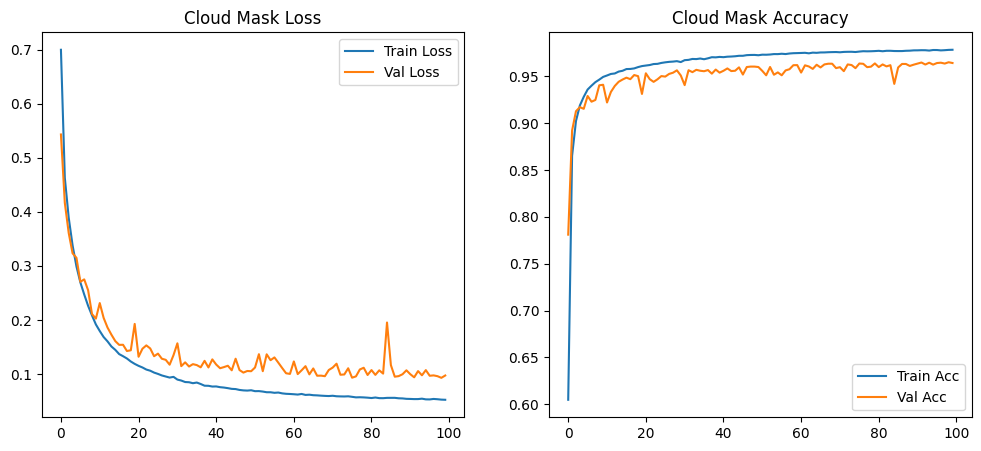

In [8]:
#PLOT LOSS and ACCURACY

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Cloud Mask Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Cloud Mask Accuracy')
plt.legend()

plt.savefig("./graphs/unet_cloud_mask.png")  

plt.show()

In [9]:
#MODEL EVALUATION

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
        
all_preds = np.concatenate([p.flatten() for p in all_preds])
all_labels = np.concatenate([l.flatten() for l in all_labels])


report = classification_report(all_labels, all_preds, digits=3, output_dict=True)
f1_scores = np.array([report[str(i)]['f1-score'] for i in range(num_classes)])
supports = np.array([report[str(i)]['support'] for i in range(num_classes)])
iou = f1_scores / (2 - f1_scores)

print("REPORT:\n", classification_report(all_labels, all_preds, digits=3))
print("CONFUSION MATRIX:\n", confusion_matrix(all_labels, all_preds))
print("\nIOU:", iou)
print("Unweighted:", np.mean(iou))
print("Weighted:", np.average(iou, weights=supports))

100%|██████████| 12/12 [00:01<00:00,  9.55it/s]


REPORT:
               precision    recall  f1-score   support

           0      0.924     0.906     0.914   5803166
           1      0.971     0.977     0.974  18740066

    accuracy                          0.960  24543232
   macro avg      0.947     0.941     0.944  24543232
weighted avg      0.960     0.960     0.960  24543232

CONFUSION MATRIX:
 [[ 5255067   548099]
 [  435274 18304792]]

IOU: [0.84236877 0.94901677]
Unweighted: 0.8956927664020939
Weighted: 0.9238002002668984
